In [ ]:
!gdown --id 1-0U11U1Z3Dp8vLHoZOtagQl25dFdza-C

In [ ]:
!pip install crcmod

In [ ]:
### samtools
!apt-get install samtools

### pysam
!pip install pysam

### picard
!wget https://github.com/broadinstitute/picard/releases/download/2.21.6/picard.jar

### GATK
!wget -O gatk-4.1.4.1.zip "https://github.com/broadinstitute/gatk/releases/download/4.1.4.1/gatk-4.1.4.1.zip"
!unzip gatk-4.1.4.1.zip
!R -e 'install.packages(c("gplots", "gsalib"))'

In [ ]:
!pip install pysam

In [ ]:
!gsutil ls gs://genomics-public-data

In [ ]:
!gsutil ls gs://genomics-public-data/resources/broad/hg38/v0

In [ ]:
!wget https://storage.googleapis.com/genomics-public-data/resources/broad/hg38/v0/Homo_sapiens_assembly38.fasta

In [ ]:
!git clone https://github.com/lh3/bwa.git
!cd bwa && make

In [ ]:
!gsutil cp -r gs://genomics-public-data/resources/broad/hg38/v0 .
!bwa/bwa mem -M -R '@RG\tID:1\tPL:Illumina\tSM:HG00096' -o file.sam {'/content/v0/Homo_sapiens_assembly38.fasta'} {'/content/drive/MyDrive/sample_3.chrom11.exome.pe1.fq'} {'/content/drive/MyDrive/sample_3.chrom11.exome.pe2.fq'}
!samtools view -b -o file.bam file.sam 
!samtools sort -o file.sorted.bam file.bam
!samtools index file.sorted.bam

 Mapirati sekvencirane readove na referentni genom hg38 upotrebom alata BWA Mem. Upotrebom python biblioteke pysam odrediti sledeće:

2a. Koliko je readova uspešno mapirano?
2b. Koliko je parova readova mapirano tako da su oba para mapirana?
2c. Nacrtati histogram dužina sekvenciranih fragmenata (template_length).

2a. Koliko je readova uspešno mapirano?

In [12]:
import pysam

print('Uspesno je mapirano :')
sum(not read.is_unmapped for read in pysam.AlignmentFile('/content/file.sorted.bam'))

Uspesno je mapirano :


4367188

Koliko je parova readova mapirano tako da su oba para mapirana?

In [ ]:
br = 0
for read in pysam.AlignmentFile('/content/file.sorted.bam'):
    if(read.is_proper_pair):
      br += 1
print(br)

4294503


2c.Nacrtati histogram dužina sekvenciranih fragmenata (template_length).

[ 167  201 -167 ... -128  146 -146]


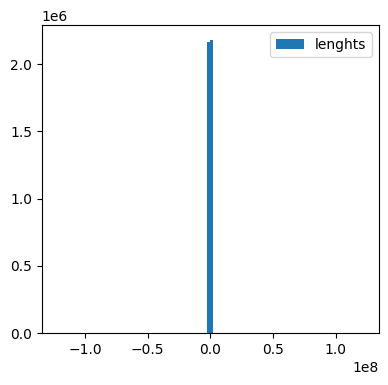

In [17]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(1, 4, 1)

bam_file = pysam.AlignmentFile('/content/file.sorted.bam', 'rb')
template_lengths = [record.template_length for record in bam_file.fetch('chr11')]
bam_file.close()
lengths = np.array(template_lengths)
print(lengths)

ax.hist(lengths, label = 'lenghts', bins = 100)
ax.legend()


In [ ]:
 Izvršiti obradu dobijenog BAM fajla prema GATK protokolu (Markiranje Duplikata, rekalibracija kvaliteta baza)

3a. Koliki su procenati PCR i optičkih duplikata?

In [ ]:
ibam = 'file.sorted.bam'
obam = 'file.deduped.bam'

!java -jar picard.jar MarkDuplicates I={ibam} O={obam} M=dup_metrics.txt

!grep -A2 '## METRICS CLASS' dup_metrics.txt | grep -v '## METRICS CLASS' > report.tsv

In [ ]:
import pandas as pd
pd.read_csv('report.tsv', sep='\t')

,LIBRARY,UNPAIRED_READS_EXAMINED,READ_PAIRS_EXAMINED,SECONDARY_OR_SUPPLEMENTARY_RDS,UNMAPPED_READS,UNPAIRED_READ_DUPLICATES,READ_PAIR_DUPLICATES,READ_PAIR_OPTICAL_DUPLICATES,PERCENT_DUPLICATION,ESTIMATED_LIBRARY_SIZE
0,Unknown Library,6571,2176759,7099,166275,3328,146477,0,0.067953,15440112


In [ ]:
146477*2 + 3328

296282

rekalibracija kvaliteta baza

In [ ]:
ibam = '/content/file.deduped.bam'
obam = 'file.recalibrated.bam'
recal = 'file.recal.table'

dbsnp = '/content/v0/Homo_sapiens_assembly38.dbsnp138.vcf'
ref = '/content/v0/Homo_sapiens_assembly38.fasta'

gatk = 'java -jar gatk-4.1.4.1/gatk-package-4.1.4.1-local.jar'

In [ ]:
!{gatk} BaseRecalibrator -I {ibam} --known-sites {dbsnp} -O {recal} --reference {ref}

In [ ]:
!{gatk} ApplyBQSR -I {ibam} -bqsr {recal} -O {obam}

In [ ]:
post_recal = 'file.post_recal.table'
!{gatk} BaseRecalibrator -I {obam} --known-sites {dbsnp} -O {post_recal} --reference {ref}

In [ ]:
!{gatk} AnalyzeCovariates -before {recal} -after {post_recal} -plots 'compare.pdf'

 Identifikovati mutacije upotrebom alata Haplotype Caller i filtirtati mutacije predefinisanim filterima (hard filtering) prema Broad preporukama (kao što je rađeno na vežbama).

4a. Koliko je ukupno mutacija identifikovano, koliko od njih su SNP-ovi, a koliko INDEL-i?
4b. Koliko mutacija prolazi, a koliko ne prolazi kriterijume filtriranja.
4c. Izračunati Ti/Tv odnos pre i posle filtriranja.

In [ ]:
gatk = 'java -jar gatk-4.1.4.1/gatk-package-4.1.4.1-local.jar'
dbsnp = '/content/v0/Homo_sapiens_assembly38.dbsnp138.vcf'
ref = '/content/v0/Homo_sapiens_assembly38.fasta'

ibam = '/content/file.recalibrated.bam'
ovcf = 'file.vcf'

!{gatk} HaplotypeCaller --input {ibam} --output {ovcf} --reference {ref} --dbsnp {dbsnp} -L chr11

In [ ]:
gatk = 'java -jar gatk-4.1.4.1/gatk-package-4.1.4.1-local.jar'

snp_f = "QD < 2.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0"
indel_f = "QD < 2.0 || FS > 200.0 || ReadPosRankSum < -20.0" 

ref = '/content/v0/Homo_sapiens_assembly38.fasta'

ivcf = '/content/file.vcf'
isvcf = 'file.snp.vcf'
iivcf = 'file.indel.vcf'


osvcf = 'file.snp.filtered.vcf'
oivcf = 'file.indel.filtered.vcf'
ovcf = 'file.filtered.vcf'

In [ ]:
!{gatk} SelectVariants -R {ref} -V {ivcf} -O {isvcf} --select-type-to-include SNP
!{gatk} VariantFiltration -R {ref} -V {isvcf} -O {osvcf} -filter "{snp_f}" --filter-name "snp"

!{gatk} SelectVariants -R {ref} -V {ivcf} -O {iivcf} --select-type-to-include INDEL
!{gatk} VariantFiltration -R {ref} -V {iivcf} -O {oivcf} -filter "{indel_f}" --filter-name "indel"

!{gatk} MergeVcfs -I {osvcf} -I {oivcf} -O {ovcf}

In [ ]:
def is_filtered(variant):
  return 'PASS' not in variant.filter

def is_snp(variant):
  return len(variant.ref) == 1 and len(variant.alts[0]) == 1

def is_transitions(variant):
  allels = set((variant.ref, variant.alts[0]))
  return allels == {'A', 'G'} or allels == {'C', 'T'}

In [ ]:
ovcf = '/content/file.filtered.vcf'

print('SNPs:',
      sum(1 for v in pysam.VariantFile(ovcf) if is_filtered(v) and is_snp(v)))

print('INDELs:',
      sum(1 for v in pysam.VariantFile(ovcf) if is_filtered(v) and not is_snp(v)))

SNPs: 187
INDELs: 4


In [ ]:
ovcf = '/content/file.filtered.vcf'
print('Filtrirani:', sum(1 for v in pysam.VariantFile(ovcf) if is_filtered(v)))
print('Nefiltrirani:', sum(1 for v in pysam.VariantFile(ovcf) if not is_filtered(v)))

Filtrirani: 191
Nefiltrirani: 13645


In [ ]:
x = '/content/file.vcf'

ti = sum(1 for v in pysam.VariantFile(x) \
         if not is_filtered(v) \
         and is_snp(v)\
         and is_transitions(v))

tv = sum(1 for v in pysam.VariantFile(x) \
          if not is_filtered(v) \
          and is_snp(v) \
          and not is_transitions(v))

print('Ti:', ti)
print('Tv:', tv)
print('Ti/Tv odnos pre filtriranja', ti/tv)

Ti: 8724
Tv: 4010
Ti/Tv odnos pre filtriranja 2.1755610972568578


In [ ]:
ti = sum(1 for v in pysam.VariantFile(ovcf) \
         if not is_filtered(v) \
         and is_snp(v)\
         and is_transitions(v))

tv = sum(1 for v in pysam.VariantFile(ovcf) \
          if not is_filtered(v) \
          and is_snp(v) \
          and not is_transitions(v))

print('Ti:', ti)
print('Tv:', tv)
print('Ti/Tv odnos posle filtriranja', ti/tv)

Ti: 8588
Tv: 3959
Ti/Tv odnos posle filtriranja 2.1692346552159636


Anotirati mutacije alatom Funcotator

5a. Izbrojati različite vrednosti ClinVar značajnosti (anotacija ClinVar_VCF_CLNSIG, koliko mutacija je označeno kao Benign, Likely_benign, itd.).

In [ ]:
!{gatk} FuncotatorDataSourceDownloader --germline --extract-after-download

In [ ]:
!cp "/content/drive/MyDrive/funcotator-funcotator_dataSources.v1.6.20190124g.tar.gz" .
!tar -xzf "funcotator-funcotator_dataSources.v1.6.20190124g.tar.gz"

In [ ]:
ivcf = '/content/file.filtered.vcf'
ovcf = 'file.annotated.vcf'
func = 'funcotator_dataSources.v1.6.20190124g/'

!{gatk} Funcotator -O {ovcf} --ref-version hg38 -R {ref} -V {ivcf} --output-file-format VCF --data-sources-path {func}

In [ ]:
reader = pysam.VariantFile(ovcf)
description = reader.header.info['FUNCOTATION'].description
print(description)
functotations = description[73:].split('|')

In [ ]:
print('\n'.join(functotations))

In [ ]:
b = 0
lb = 0
b_lb = 0

for variant in pysam.VariantFile(ovcf):
  ann = {x:y for x, y in zip(functotations, 
                             variant.info['FUNCOTATION'][0][1:-1].split('|'))}

  if ann['ClinVar_VCF_CLNSIG'] == 'Benign':
    b += 1
  elif ann['ClinVar_VCF_CLNSIG'] == 'Likely_benign':
    lb += 1
  elif ann['ClinVar_VCF_CLNSIG'] == 'Benign/Likely_benign':
    b_lb += 1
    
print('Benign: ')
print(b)
print('Likely_benign: ')
print(lb)
print('Benign/Likely_benign: ')
print(b_lb)

Benign: 
265
Likely_benign: 
25
Benign/Likely_benign: 
46


Svi uzorici sadrže određenu količinu kontaminacije DNK materijalom bakterijskog ili virusnog porekla. Većina ovakvih readova se neće mapirati na ljudski genom. Izvući readove koji nisu mapirani u procesu mapiranja, asemblovati ih alatom abyss, i identifikovati organizam od kojeg potiče najduži skafold upotrebom alata Blast.

In [ ]:
!sudo apt-get install autotools-dev automake
!git clone https://github.com/bcgsc/abyss.git
!cd abyss && ./autogen.sh
!cd abyss && ./configure
!cd abyss && make
!cd abyss && sudo make install
 
!sudo apt-get install abyss

In [ ]:
!wget https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/2.10.0/setup-apt.sh
!sudo sh setup-apt.sh

In [ ]:
# Prazan FASTQ fajl
fastq_file = '/content/drive/MyDrive/novi.fastq'

# Otvaranje fajla u režimu pisanja
with open(fastq_file, 'w') as f:
    pass

# Potvrda završetka
print(f'Prazan FASTQ fajl {fastq_file} je uspešno generisan.')


Prazan FASTQ fajl /content/drive/MyDrive/novi.fastq je uspešno generisan.


In [ ]:
from Bio import SeqIO
import pysam

# Putanja do BAM fajla
bam_file = '/content/file.sorted.bam'

# Otvorite BAM fajl za čitanje
bam = pysam.AlignmentFile(bam_file, 'rb')

# Kreirajte praznu listu za čuvanje ne-mapiranih readova
unmapped_reads = []

# Iterirajte kroz svaki read u BAM fajlu
for read in bam.fetch():
    if read.is_unmapped:  # Proverite da li je read ne-mapiran
        unmapped_reads.append(read.query_sequence)

# Zatvorite BAM fajl
bam.close()

# Putanja do izlaznog FASTQ fajla
fastq_file = '/content/drive/MyDrive/novi.fastq'

# Kreiranje i čuvanje FASTQ zapisa za nemapirane readove
seq_records = []
for i, seq in enumerate(unmapped_reads):
    seq_record = SeqIO.SeqRecord(Seq(seq), id=f'read{i+1}', description='')
    seq_record.letter_annotations["phred_quality"] = [40] * len(seq)  # Postavljamo podrazumevanu vrednost kvaliteta
    seq_records.append(seq_record)

SeqIO.write(seq_records, fastq_file, 'fastq')

print(f'FASTQ fajl sa nemapiranim readovima je uspešno kreiran: {fastq_file}')


FASTQ fajl sa nemapiranim readovima je uspešno kreiran: /content/drive/MyDrive/novi.fastq


In [ ]:
!abyss-pe name=chr11 k=64 in='/content/drive/MyDrive/sample_3.chrom11.exome.pe1.fq /content/drive/MyDrive/sample_3.chrom11.exome.pe2.fq'

In [ ]:
import pysam

freader = pysam.FastaFile('/content/drive/MyDrive/novi.fastq')

In [ ]:
list(zip(freader.lengths, freader.references))

In [ ]:
max_ref = sorted(zip(freader.lengths, freader.references), reverse=True)[0]
max_ref

(301, 'read9')

In [ ]:
freader.fetch(max_ref[1])

'GTTTTAGGGCCCGGACGGTGATGCGCGCGTTGCGGAACGGGGCGGGGTTCGCGTCAAATGCCGCGCGAATATCCGGAGCGTGCGGAGTACAGACCAGGTTTTGACAGAGTTCGCGCAGGACAGTGGCGGTCCATTGTGCCTTCAGTCCTTCCGGATGCAGGATTTCTTCGGCTCCGTCGGCCCGGAGACGCCGCCGCTCGCCGCTGAGTTGACCGATAATCTTGAGTGCAACAGCAATGAGAGCAGGACGACTGTGGGAGAGCAGGTCGGTGAACAGCGGCGAGTCCATAGTGATCCACAG'